In [10]:
# Case Western BVD Data
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import zscore
import os
import mass_ts as mts # https://github.com/matrix-profile-foundation/mass-ts
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import pandas as pd

from experimentsetup import *
from preprocessingandrecords import *
from tqdm import tqdm

main_dir = "BVDCaseWestern/"
CYCLELEN = 2000
NUMPAT = 3
SENSOR_root = 'FE_time'
exp = Experiment("PRECIS", [NUMPAT, CYCLELEN//2])

In [11]:
dataset, labels = [], []
for (root,dirs,files) in os.walk(main_dir):
    print("files: {}".format(files))
    for f in files:
        SENSOR = None
        data = loadmat(main_dir+f) 
        dkeys = data.keys()
        for k in dkeys:
            if SENSOR_root in k:
                SENSOR = k
        data = zscore(data[SENSOR],nan_policy="omit")
        INCREMENT_SCALE = 25
        increment_len = CYCLELEN*INCREMENT_SCALE
        n_increments = len(data)//increment_len
        s,e = 0, increment_len
        for i in range(1,n_increments+1):
            e = s + increment_len
            if i == n_increments+1:
                dataset.append(data[s:])
            else:
                dataset.append(data[s:e])
                s = e+1
            l = f[-5]
            labels.append(int(l))

files: ['100_load3.mat', '99_load2.mat', '97_load0.mat', '98_load1.mat']


In [12]:
df_dataset = pd.DataFrame(np.squeeze(dataset))
df_dataset['label'] = labels
load0_df = df_dataset[df_dataset['label']==0]
load1_df = df_dataset[df_dataset['label']==1]
load2_df = df_dataset[df_dataset['label']==2]
load3_df = df_dataset[df_dataset['label']==3]

In [15]:
def prettyjoin(tses):
    overlap = 30
    ts1 = np.array(tses[0])
    l1 = len(ts1)
    ts2 = tses[1]
    tstemp = np.subtract(ts1[l1-overlap:],ts2[1:overlap+1])
    loc = np.argmin(zscore(tstemp,nan_policy='omit')) 
    ts_ret = np.concatenate((ts1,ts2[loc-1:]))
    return ts_ret

def chunkts(ts,chunklen=None,numchunks=None):
    if chunklen == None:
        chunklen = len(ts)//numchunks
    if numchunks == None:
        numchunks = len(ts)//chunklen
    chunked = [np.array(ts[(j*chunklen):(j*chunklen)+chunklen]) for j in range(numchunks-1)]
    return chunked


def interleavechunks(chunkset1, chunkset2):
    interleaved = prettyjoin([chunkset1[0],chunkset2[0]])
    n = "01"
    r = min(len(chunkset1),len(chunkset2))
    for j in range(1,r):
        interleaved = prettyjoin([interleaved,chunkset1[j]])
        interleaved = prettyjoin([interleaved,chunkset2[j]])
        n+="01"
    return interleaved, n # concatenated chunks, prettyjoined


def interleavedfakedata(subset,chunklen):
    fakedata = []
    n = ""
    for i in tqdm(range(len(subset)),desc="Making fake data"):
        ts1_p, ts2_p = subset[i]
        ts1 = chunkts(ts1_p,chunklen=chunklen)
        ts2 = chunkts(ts2_p,chunklen=chunklen)
        ts_ret, m = interleavechunks(ts1,ts2)
        fakedata.append(ts_ret)
        n+=m
    fakedata = np.concatenate((fakedata[0],fakedata[1]))
    return fakedata, n


def makefakedata(fakedata, insertsequence):
    insertionpoint = len(fakedata)//2
    startloc = insertionpoint
    firsthalf = np.asarray(fakedata[:insertionpoint])
    secondhalf = np.asarray(fakedata[insertionpoint:])
    if len(firsthalf.shape) > 1:
        firsthalf =np.squeeze(firsthalf)
    if len(secondhalf.shape) > 1:
        secondhalf = np.squeeze(secondhalf)
    ts_ret = prettyjoin([firsthalf,insertsequence])
    endloc = len(ts_ret)
    ts = prettyjoin([ts_ret,secondhalf])
    return ts, startloc, endloc

In [16]:
sourcets = zscore(load3_df.iloc[0],nan_policy="omit")
lowlitsource, n = interleavedfakedata([(zscore(load0_df.iloc[0],nan_policy="omit"),zscore(load1_df.iloc[0],nan_policy="omit")),(zscore(load0_df.iloc[1],nan_policy="omit"),zscore(load1_df.iloc[1],nan_policy="omit"))],CYCLELEN)
lowlitdict, lowlitidxs = exp.make_exemplar(lowlitsource)
subsetpairs = [(zscore(load0_df.iloc[3],nan_policy="omit"),zscore(load1_df.iloc[3],nan_policy="omit")),
(zscore(load0_df.iloc[2],nan_policy="omit"),zscore(load1_df.iloc[2],nan_policy="omit"))]
fakedata_og, n = interleavedfakedata(subsetpairs,CYCLELEN)
fakedata,startloc,endloc = makefakedata(fakedata_og, sourcets[300:8320]) 
print(startloc,endloc,len(fakedata_og),len(fakedata),len(sourcets[300:8320]))

Making fake data: 100%|██████████| 2/2 [00:00<00:00, 99.33it/s]

80532 88542 161065 169056 8020


In [17]:
def masswrapper(ts,query):
    p2s = [2,4,8,16,32,64,128,256,512,1024,2048,4096]
    lb = len(query)
    ub = len(ts)
    for p in p2s:
        if p >= lb and p <= ub:
            break
    else:
        p = lb
    if len(ts) - p + 1 < 1:
        print(len(ts), len(query), p)
        print("!!!!!!! WARNING: p is larger than the length of ts (and this is not okay) !!!!!!!")
        quit()
    return mts.mass3(ts,query,p)


def precis_se(dps):
    medians = np.median(dps,axis=0)
    return medians**2


def paddps(dps):
    padto = max([len(dp) for dp in dps])
    for i in range(len(dps)):
        curr = dps[i]
        dps[i] = np.pad(curr, (0,abs(padto-len(curr))), 'constant', constant_values=(0))
    return dps


In [18]:
from tqdm import tqdm
from scipy.io import savemat

# SMOOTH = CYCLELEN+1
# STRIDE = CYCLELEN//16
def plotexandnnts(ts, load_dict, load_idxs, locstart, locend): # ts is fakedata
    colors_dict=['c','m','y','r','g','b','k','limegreen','cornflowerblue','salmon']
    loadcolors = {"0":'r',"1":"steelblue","2":"rebeccapurple","3":"deepskyblue"}
    fig = plt.figure(tight_layout=True, figsize=(25,8))
    gs = gridspec.GridSpec(4, len(load_idxs))

    for p in tqdm(range(len(load_idxs))):
        ax_pattern = fig.add_subplot(gs[0,p])
        pattern = load_dict[p]
        ax_pattern.plot(np.arange(len(pattern)),pattern,c=colors_dict[p])
        ax_pattern.set_title("Pattern {}".format(p))

    start = 0
    axs_fakedata = fig.add_subplot(gs[1,:])
    axs_fakedata.plot(np.arange(len(ts)),ts,c='gainsboro')
    axs_fakedata.plot(np.arange(locstart,locend), ts[locstart:locend],label="Inserted High Load",c="gold")
    axs_fakedata.set_xlim([0,len(fakedata)])
    axs_fakedata.set_title("Synthetic Data Example")
    axs_fakedata.legend()

    dps = []
    axs_dps = fig.add_subplot(gs[2,:])
    axs_dps.set_title("Pattern Distance Profiles")
    # ts = smooth(ts,3)
    for p in tqdm(range(len(load_idxs))):
        query = np.squeeze(load_dict[p]) # when numpat=1, np squeeze
        # dp = zscore(abs(masswrapper(ts,query)),nan_policy='omit')
        dp = abs(masswrapper(ts,query))
        # dp = smooth(dp,SMOOTH)
        # dp = dp[SMOOTH:-SMOOTH]
        # dp = movemin(dp,STRIDE)
        axs_dps.plot(np.arange(len(dp)),dp,c=colors_dict[p]) # plot dp
        axs_dps.set_xlim([0,len(fakedata)])
        dps.append(dp)
    
    m = min([len(a) for a in dps])
    dps = paddps(dps)
    final = precis_se([np.array(t[:m-1]) for t in dps]) # formerly "s"
    # final = s[SMOOTH:m-SMOOTH]
    axs_PRECISProfile = fig.add_subplot(gs[3,:])
    # axs_PRECISProfile.plot(np.arange(SMOOTH,m-(SMOOTH)),final,c="k")
    axs_PRECISProfile.plot(np.arange(len(final)),final,c="k")
    axs_PRECISProfile.set_xlim([0,len(fakedata)])
    axs_PRECISProfile.set_title("PRECIS PROFILE")
    # plt.savefig("<save location>",fmt='svg')
    plt.show()

    ad_data = {'patterns':load_dict, 'syntheticdata': ts,'distanceprofiles':dps, 'PRECISprofile':final, 'highloadstart':locstart, 'highloadend':locend}
    # savemat('<savelocation>.mat', ad_data)
    return

100%|██████████| 3/3 [00:09<00:00,  3.27s/it]


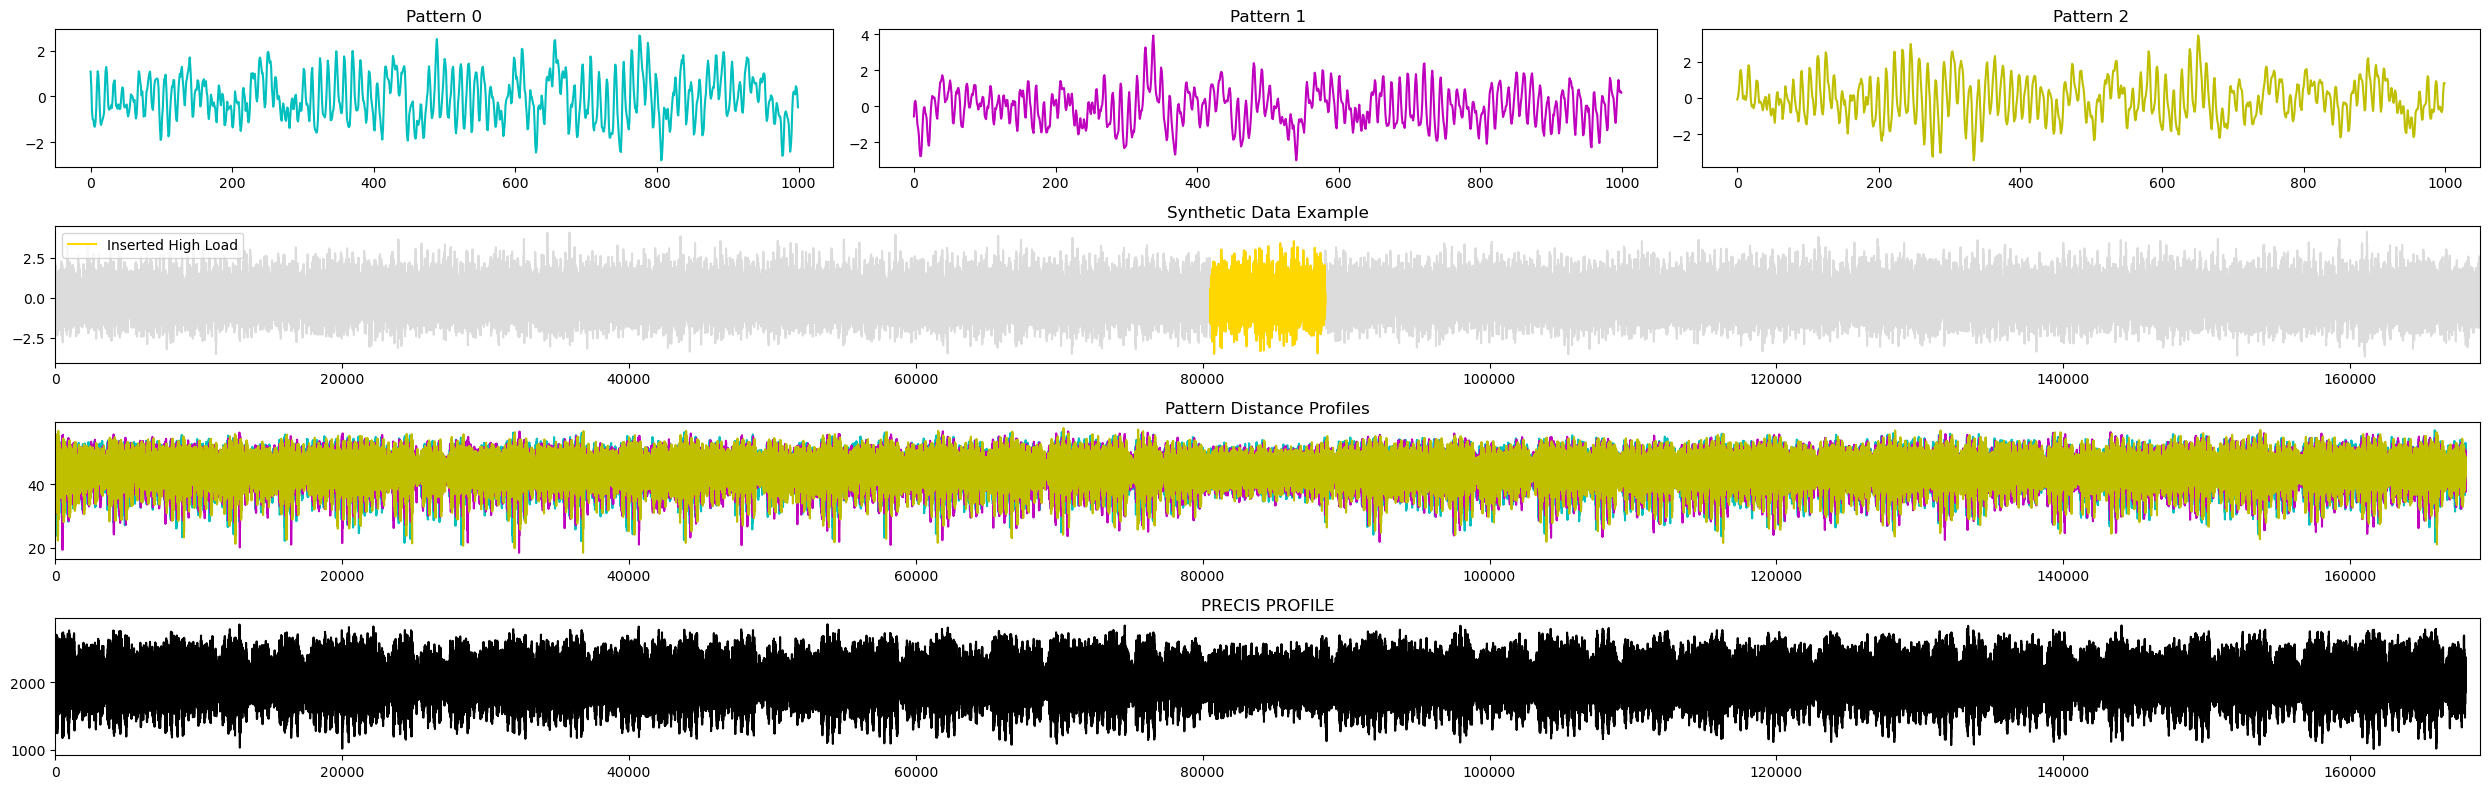

In [19]:
plotexandnnts(fakedata, lowlitdict, lowlitidxs, startloc, endloc)